In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
!pip install TPOT
from tpot import TPOTClassifier
from sklearn.model_selection import cross_val_score
import pickle

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/diabetes.csv", encoding = "ISO-8859-1")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
for futures in df:
  print(futures,df[futures].isnull().sum())

Pregnancies 0
Glucose 0
BloodPressure 0
SkinThickness 0
Insulin 0
BMI 0
DiabetesPedigreeFunction 0
Age 0
Outcome 0


feature like insuline,skin thickness and glucose has zeros in it but in real life it doesn'nt have those so we have to convert those zero values to median of those features.

In [6]:
df['Glucose'] = np.where(df['Glucose'] == 0,df['Glucose'].median(),df['Glucose'])
df['SkinThickness'] = np.where(df['SkinThickness'] == 0,df['SkinThickness'].median(),df['SkinThickness'])
df['Insulin'] = np.where(df['Insulin'] == 0,df['Insulin'].median(),df['Insulin'])


In [7]:
numerical_futures = [future for future in df.columns if df[future].dtype !='O']
len(numerical_futures)
df[numerical_futures].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72,35.0,30.5,33.6,0.627,50,1
1,1,85.0,66,29.0,30.5,26.6,0.351,31,0
2,8,183.0,64,23.0,30.5,23.3,0.672,32,1
3,1,89.0,66,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40,35.0,168.0,43.1,2.288,33,1


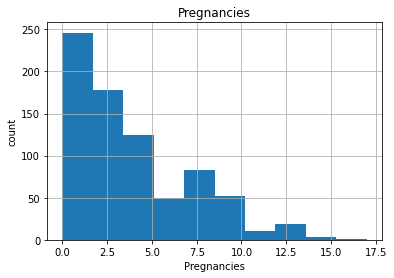

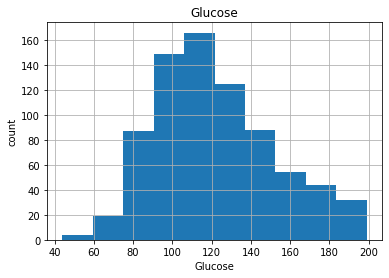

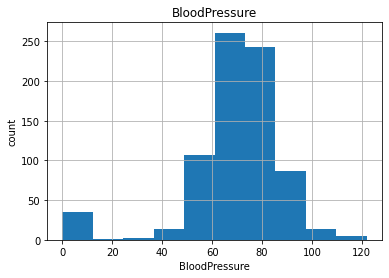

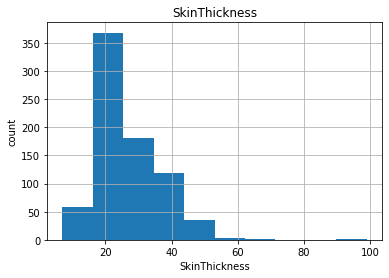

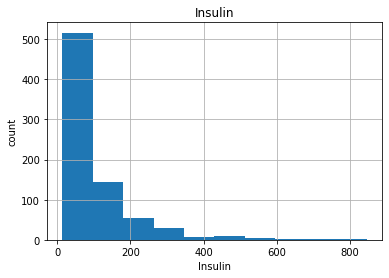

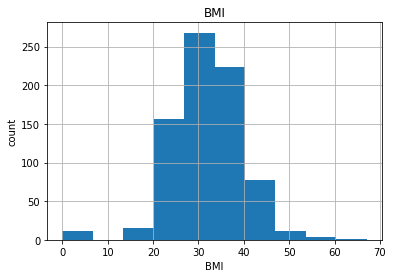

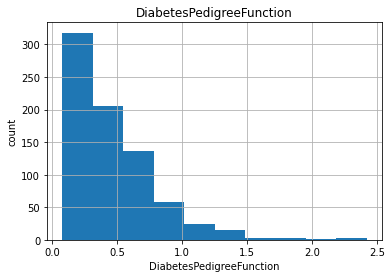

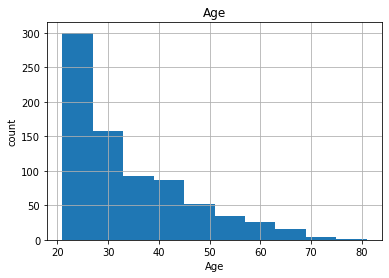

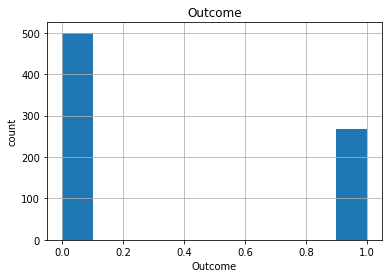

In [8]:
for future in numerical_futures:
  data = df.copy()
  data[future].hist()
  plt.xlabel(future)
  plt.ylabel('count')
  plt.title(future)
  plt.show()

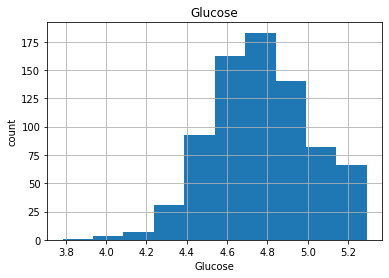

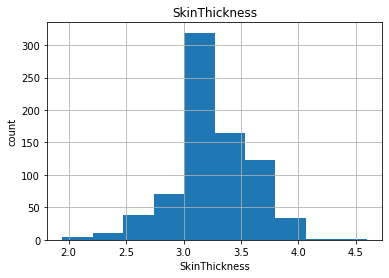

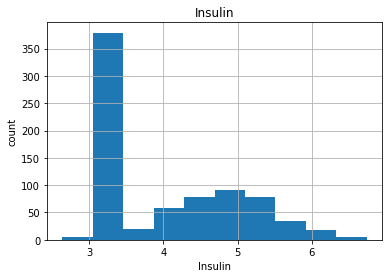

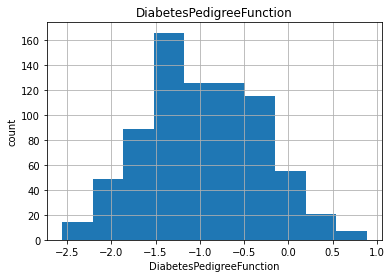

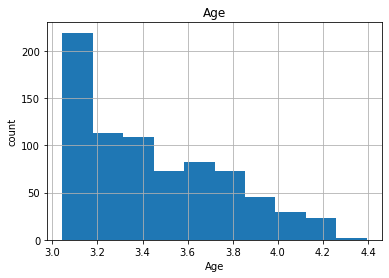

In [9]:
for feature in numerical_futures:
  data = df.copy()
  if 0 in data[feature].unique():
    pass
  else:
    data[feature]=np.log(data[feature])
    data[feature].hist()
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.title(feature)
    plt.show()

## Just to find the outliers

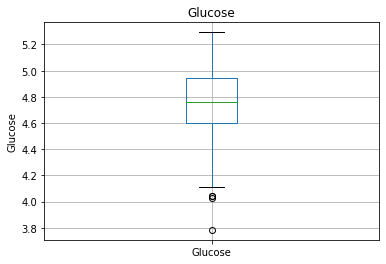

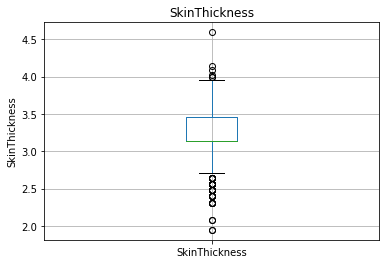

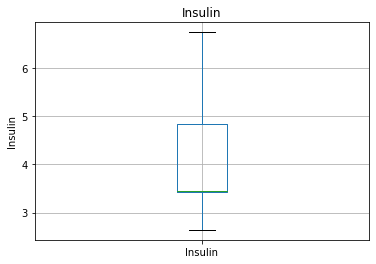

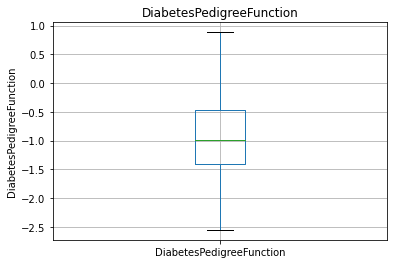

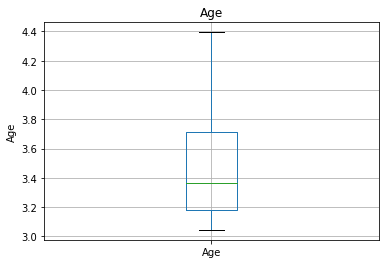

In [10]:

for feature in numerical_futures:
    data=df.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature]=np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

In [11]:
X = df.drop('Outcome',axis=1)

In [12]:
y = df['Outcome']

# **Future selection checking the constant futures


In [13]:
vari_thresh = VarianceThreshold(threshold=0)
vari_thresh.fit(X)

VarianceThreshold(threshold=0)

In [14]:
vari_thresh.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [15]:
sum(vari_thresh.get_support())

8



# So their are no constant features



## So applying chisquare test for future selection

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [17]:
ordered_rank_features=SelectKBest(score_func=chi2,k=8)
ordered_feature=ordered_rank_features.fit(X,y)


In [18]:
scores = pd.DataFrame(ordered_rank_features.scores_,columns=['Scores'])
columns = pd.DataFrame(X.columns,columns=['Feature'])

In [19]:
features_rank_chi = pd.concat([scores,columns],axis=1)
features_rank_chi

,Scores,Feature
0,111.519691,Pregnancies
1,1418.442397,Glucose
2,17.605373,BloodPressure
3,85.431282,SkinThickness
4,1989.589394,Insulin
5,127.669343,BMI
6,5.392682,DiabetesPedigreeFunction
7,181.303689,Age


In [20]:
main_rank_chi = features_rank_chi.nlargest(5,'Scores')

In [21]:
feature_col = main_rank_chi['Feature']
df_chi = df[feature_col]
df_chi

,Insulin,Glucose,Age,BMI,Pregnancies
0,30.5,148.0,50,33.6,6
1,30.5,85.0,31,26.6,1
2,30.5,183.0,32,23.3,8
3,94.0,89.0,21,28.1,1
4,168.0,137.0,33,43.1,0
...,...,...,...,...,...
763,180.0,101.0,63,32.9,10
764,30.5,122.0,27,36.8,2
765,112.0,121.0,30,26.2,5
766,30.5,126.0,47,30.1,1


# So let us check this with pearson correlation for feature selection


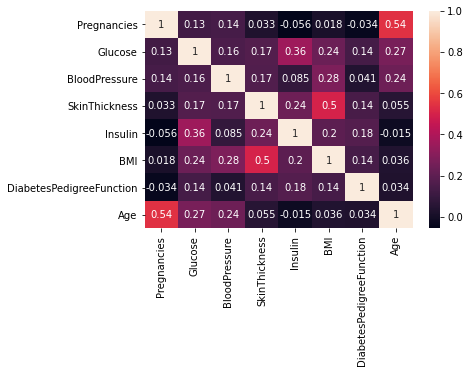

In [22]:
import seaborn as sns
corr=X.corr()
top_features=corr.index

sns.heatmap(df[top_features].corr(),annot=True)

Their is'nt many feature that have high correlation with each other so pass and use the feature that we got from chisquare test


lets give it a try with information gain one of the feature selection techniques


In [23]:
mutual_info=mutual_info_classif(X,y)


In [24]:
mutual_info

array([0.04537494, 0.13049495, 0.        , 0.00512815, 0.07003008,
       0.0798183 , 0.01059588, 0.0620218 ])

In [25]:


mu_scores = pd.DataFrame(mutual_info,columns=['scores'])
mu_futures = pd.DataFrame(X.columns,columns=['Features'])

In [26]:
features_rank_mu = pd.concat([mu_scores,mu_futures],axis=1)
features_rank_mu

,scores,Features
0,0.045375,Pregnancies
1,0.130495,Glucose
2,0.000000,BloodPressure
3,0.005128,SkinThickness
4,0.070030,Insulin
5,0.079818,BMI
6,0.010596,DiabetesPedigreeFunction
7,0.062022,Age


In [27]:
main_rank_mu = features_rank_mu.nlargest(5,'scores')
main_rank_mu

,scores,Features
1,0.130495,Glucose
5,0.079818,BMI
4,0.070030,Insulin
7,0.062022,Age
0,0.045375,Pregnancies


In [28]:
feature_col_mu = main_rank_mu['Features']
df_mu = df[feature_col_mu]
df_mu

,Glucose,BMI,Insulin,Age,Pregnancies
0,148.0,33.6,30.5,50,6
1,85.0,26.6,30.5,31,1
2,183.0,23.3,30.5,32,8
3,89.0,28.1,94.0,21,1
4,137.0,43.1,168.0,33,0
...,...,...,...,...,...
763,101.0,32.9,180.0,63,10
764,122.0,36.8,30.5,27,2
765,121.0,26.2,112.0,30,5
766,126.0,30.1,30.5,47,1


From both chi test and mutual information test we got some of the features so we take the union of those features and use those features.
# Pregnancies', 'Glucose',  'SkinThickness', 'Insulin',
##       'BMI',  'Age'

In [29]:
main_features = pd.concat([feature_col_mu,feature_col])

In [30]:
main_features.unique()

array(['Glucose', 'BMI', 'Insulin', 'Age', 'Pregnancies'], dtype=object)

In [31]:
df_main = df[main_features.unique()]

In [32]:
df_main.head()

,Glucose,BMI,Insulin,Age,Pregnancies
0,148.0,33.6,30.5,50,6
1,85.0,26.6,30.5,31,1
2,183.0,23.3,30.5,32,8
3,89.0,28.1,94.0,21,1
4,137.0,43.1,168.0,33,0


In [33]:
X = df_main


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=0)
X_train.shape,y_train.shape

((614, 5), (614,))

In [35]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=0)
rf_classifier.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [36]:
prediction = rf_classifier.predict(X_test)

In [37]:
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[95 12]
 [17 30]]
0.8116883116883117
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       107
           1       0.71      0.64      0.67        47

    accuracy                           0.81       154
   macro avg       0.78      0.76      0.77       154
weighted avg       0.81      0.81      0.81       154



In [38]:
n_estimators = [ int(x) for x in np.linspace(start = 10,stop = 1000,num = 100)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 600,100)]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [1,3,4,5,6,7,8]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)


{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87, 93, 99, 105, 111, 117, 123, 129, 135, 141, 147, 153, 158, 164, 170, 176, 182, 188, 194, 200, 206, 212, 218, 224, 230, 236, 242, 248, 254, 260, 266, 272, 278, 284, 290, 296, 302, 307, 313, 319, 325, 331, 337, 343, 349, 355, 361, 367, 373, 379, 385, 391, 397, 403, 409, 415, 421, 427, 433, 439, 445, 451, 456, 462, 468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,

In [39]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)

rf_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [40]:
rf_randomcv.best_params_

{'criterion': 'gini',
 'max_depth': 111,
 'max_features': 'log2',
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 920}

In [41]:
best_random_grid=rf_randomcv.best_estimator_

In [42]:
from sklearn.metrics import accuracy_score
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[96 11]
 [16 31]]
Accuracy Score 0.8246753246753247
Classification report:               precision    recall  f1-score   support

           0       0.86      0.90      0.88       107
           1       0.74      0.66      0.70        47

    accuracy                           0.82       154
   macro avg       0.80      0.78      0.79       154
weighted avg       0.82      0.82      0.82       154



In [43]:
param_grid = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']+5,
                   rf_randomcv.best_params_['max_depth'],
                  rf_randomcv.best_params_['max_depth']-5],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         ],
    'min_samples_split': [
                          rf_randomcv.best_params_['min_samples_split'], 
                          ],
    'n_estimators': [
                     rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] + 3,rf_randomcv.best_params_['n_estimators'] + 5]
}

print(param_grid)

{'criterion': ['gini'], 'max_depth': [116, 111, 106], 'max_features': ['log2'], 'min_samples_leaf': [8], 'min_samples_split': [5], 'n_estimators': [920, 923, 925]}


In [44]:
rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=3,n_jobs=-1,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   34.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [45]:

grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=111, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=925,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
best_grid=grid_search.best_estimator_

In [47]:
y_pred=best_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[96 11]
 [16 31]]
Accuracy Score 0.8246753246753247
Classification report:               precision    recall  f1-score   support

           0       0.86      0.90      0.88       107
           1       0.74      0.66      0.70        47

    accuracy                           0.82       154
   macro avg       0.80      0.78      0.79       154
weighted avg       0.82      0.82      0.82       154



In [48]:

tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': random_grid}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(X_train,y_train)


Generation 1 - Current best internal CV score: 0.7589444868856634

Generation 2 - Current best internal CV score: 0.7589444868856634

Generation 3 - Current best internal CV score: 0.7589444868856634

Generation 4 - Current best internal CV score: 0.7589444868856634

Generation 5 - Current best internal CV score: 0.7589444868856634

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=gini, max_depth=194, max_features=auto, min_samples_leaf=8, min_samples_split=3, n_estimators=390)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [10,
                                                                                      15,
                                                                                      21,
                                                                                      27,
                                                                                      33,
                                                                                      39,
                                                                                      45,
                                                                                      51,
                                                                                      57

In [50]:
accuracy = tpot_classifier.score(X_test, y_test)
print(accuracy)

0.8181818181818182


In [52]:
pickle.dump(rf, open('diabetes_model.pkl','wb'))